## <center> INTRACRANIAL HEMORRHAGES DATABASE - RANDOM SURVIVAL FOREST, GRADIENT BOOSTED MODELS & ACCELERATED FAILURE TIME MODEL</center>

This Notebook explores models based on **Random Survival Forest** and **Gradient Boosted** techniques, including a parametric approach for survival function estimation, the well-known **Accelerated Failure Time** approach.


**1. Load dataset**

**2. Random Survival Forests**

- **Training**
    - Depth of Survival trees.
    - Number of base learners.
    - Find the optimal hyperparameters.
    
- **Testing**
    - Permutation-based feature importance.
    - Bootstrapping confidence intervals.
    
- **Predicting**


**3. Gradient Boosted Model**

- **Training**
    - **Survival trees**
        - Study the optimal number of base learners.
        - Find the optimal hyperparameters.
    - **Component-wise least squares**
        - Study the optimal number of base learners.
        - Find the optimal hyperparameters.
        
- **Testing**
    - Feature importance.
        - GB tree.
        - GB least squares.
    - Bootstrapping confidence intervals.

    
- **Predicting**


**4. Accelerated Failure Time Model**

- **Training**
    - Study the optimal number of base learners.
    - Find the optimal hyperparameters.
        
- **Testing**
    - Feature importance.
    - Bootstrapping confidence intervals.
    
- **Predicting**

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sksurv.util import Surv
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
from time import time

### 1. Load dataset

In [2]:
df= pd.read_hdf('Databases/ICH_database.hdf5')
df_metadata= pd.read_csv('Databases/ICH_database_metadata.csv')
df.head(4)

,patient,sex,hospital,follow_up,final_outcome,nfamily_medhist,tobacco,n_tobacco,drugs,alcohol,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,time_between_CT_bloodanalysis,age,survival_days
0,1,1,1.0,2.0,2.0,17,2.0,NaN,0,0,...,17.0,33.0,9.0,28.1,4.21,344.0,618.0,0,74,4
1,2,2,2.0,0.0,1.0,4,0.0,0.0,0,0,...,14.7,32.5,10.7,29.8,NaN,NaN,1081.0,0,81,2128
2,3,2,1.0,0.0,0.0,8,0.0,0.0,0,0,...,14.0,33.1,8.7,30.1,3.16,298.0,470.0,0,78,2388
3,4,2,1.0,2.0,2.0,8,0.0,0.0,0,0,...,15.8,34.1,7.6,19.3,1.09,344.0,344.0,0,79,7


#### 1.1. Select predictors

In [3]:
# Selection of some predictors to have enought sample after removing NaNs
predictors= ['sex','nfamily_medhist', 'ht', 'dmellitus', 'dyslipidemia', 'structural_heart_disease',
             'neurological_diseases',
             'antihypertensives', 'antidiabetics', 'hypolipidemics', 'anticoagulants', 'antiplatelets',
             'aspirin', 'cumarinics',
             'headache', 'emesis', 'visual_disturbances', 'seizures',
             'neurol_signs', 'anisocoria', 'altered_consciousness',
             'ruplimb_mimpairment', 'luplimb_mimpairment', 'rlwlimb_mimpairment', 'llwlimb_mimpairment',
             'balance_impairment', 'tgcs', 'onset_h',
             'primary_ich',
             'glucose', 'urea', 'creatinine', 'potasium', 'prothrombin_activity', 'hematocrit', 'maxfibrinogen',
             'age']

In [4]:
df_X= df[predictors]
df_X_nonan= df_X.dropna(axis=0)

#### 1.2. Define outcomes

In [5]:
Status= np.array(df['survival_discharge'] == 0) # old value 0 (death), is changed for new value True or 1 (death)
Survival_in_days= np.array(df['survival_days'])

In [6]:
y= Surv().from_arrays(event=Status, time=Survival_in_days, name_event='Status', name_time='Survival_in_days')
y_nonan= y[df_X_nonan.index]

### 2. Random Survival Forests

- **Training**
    - Depth of Survival trees.
    - Number of base learners.
    - Find the optimal hyperparameters.
- **Testing**
    - Permutation-based feature importance.
    - Bootstrapping confidence intervals.
- **Predicting**

A **Random Survival Forest (RST)** is very similar to a standard Random Forest (RF), the difference is that RST are based on **survival trees**, whose quality of split is measured by the **log-rank** splitting rule, instead of by gini impurity, entropy or information gain. A Random Survival Forest is an ensemble of de-correlated survival tree-based learners. They are considered as one of the best Machine Learning techniques for solving classification an regression problems. Individual trees of the ensemble are built on a different bootstrap sample of the original training data, and at each node, the split criterion is only evaluated for a randomly selected subset of features and thresholds. These two issues ensure de-correlation.

Random Survival Forest and their survival trees are based on partitioning the data to make predictions, therefore, standarization or normalization is not required.

### 2.1. Training

- **Depth of Survival trees**.
- **Number of base learners**.
- **Find the optimal hyperparameters**.

In [7]:
X_train, X_test, y_train, y_test= train_test_split(df_X_nonan, y_nonan, test_size=0.25, random_state=0)

#### 2.1.1. Depth of Survival trees

First of all, train a RSF with maximum depth trees despite they will be overfitted to explore which can be the optimal depth and guide the *GridSearch*.

In [8]:
# Define a Random Survival Forest
rsf_depth= RandomSurvivalForest(n_estimators=200,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                bootstrap=True,
                                n_jobs=-1,
                                random_state=0)

# Fit the model
rsf_depth.fit(X_train, y_train)

# Test on test data
c_index= rsf_depth.score(X_test, y_test)
print('RSF c-index: %.4f' % (c_index))

RSF c-index: 0.6965


In [9]:
st_depths= [st.tree_.max_depth for st in rsf_depth.estimators_]
print('Base learners depth (mean, 95%%IC): %.0f [%.0f,%.0f] nodes' % (np.mean(st_depths), (np.mean(st_depths) - 1.96*np.std(st_depths)), (np.mean(st_depths) + 1.96*np.std(st_depths))))

Base learners depth (mean, 95%IC): 9 [6,12] nodes


In [10]:
rsf_depth2= RandomSurvivalForest(n_estimators=200,
                                 min_samples_leaf=1,
                                 min_samples_split=8,
                                 bootstrap=True,
                                 n_jobs=-1,
                                 random_state=0,
                                 max_samples=int(df_X_nonan.shape[0]/10))

param_grid_rsf_depth= {'max_depth': list(range(1,12))}

cv= KFold(n_splits=10, shuffle=True, random_state=0)

rgcv_depth= GridSearchCV(estimator=rsf_depth2,
                         param_grid=param_grid_rsf_depth,
                         error_score='raise',
                         n_jobs=1,
                         cv=cv).fit(df_X_nonan, y_nonan)

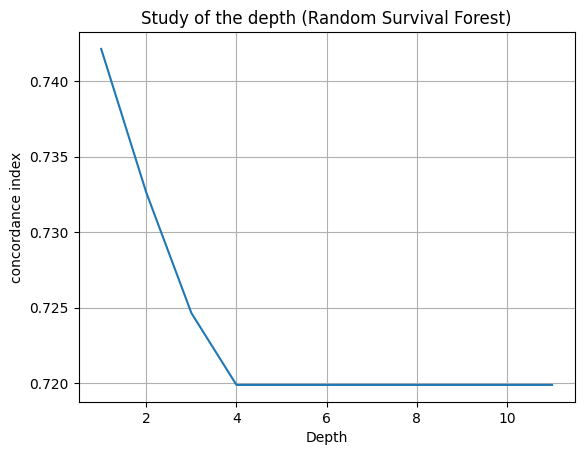

In [11]:
fig= plt.figure()
plt.plot(list(range(1,12)), pd.DataFrame(rgcv_depth.cv_results_)['mean_test_score'])
plt.title('Study of the depth (Random Survival Forest)')
plt.ylabel('concordance index')
plt.xlabel('Depth')
plt.grid(True)

#### 2.1.2. Number of base learners

Study the progression of *c-index* when increasing the number of base learners.

In [12]:
rsf_= RandomSurvivalForest(max_depth=4,
                           min_samples_leaf=1,
                           min_samples_split=8,
                           bootstrap=True,
                           n_jobs=-1,
                           random_state=0,
                           max_samples=int(df_X_nonan.shape[0]/10))

param_grid_rsf= {'n_estimators': list(range(100,1000,50))}

rgcv_= GridSearchCV(estimator=rsf_,
                    param_grid=param_grid_rsf,
                    error_score='raise',
                    n_jobs=1,
                    cv=cv).fit(df_X_nonan, y_nonan)

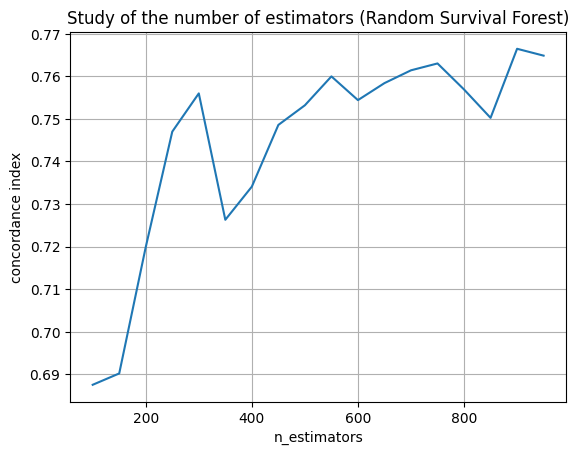

In [13]:
fig= plt.figure()
plt.plot(list(range(100,1000,50)), pd.DataFrame(rgcv_.cv_results_)['mean_test_score'])
plt.title('Study of the number of estimators (Random Survival Forest)')
plt.ylabel('concordance index')
plt.xlabel('n_estimators')
plt.grid(True)

#### 2.1.3. Find the optimal hyperparameters

Now, find the optimal hyperparameters.

In [14]:
# Find the optimal Random Survival Forest hyperparameters

rsf= RandomSurvivalForest(bootstrap=True, n_jobs=-1, random_state=0, max_samples=int(df_X_nonan.shape[0]/10))


param_grid_rsf= {'n_estimators': [200],
                 'max_depth': [3,4],
                 'min_samples_split': [4,6,8],
                 'min_samples_leaf': [1,2]}

cv= KFold(n_splits=10, shuffle=True, random_state=0)

rgcv= GridSearchCV(estimator=rsf,
                   param_grid=param_grid_rsf,
                   error_score='raise',
                   n_jobs=1,
                   cv=cv)


t0= time()
rgcv.fit(df_X_nonan, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(rgcv.best_params_, '\n')
print('Best score: %.4f' % (rgcv.best_score_))

Fitting time: 0.50 min 

Best hyperparameters:
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200} 

Best score: 0.7304


In [15]:
# Final model
model_rsf= RandomSurvivalForest(bootstrap=True, n_jobs=-1, random_state=0, max_samples=int(X_train.shape[0]))
model_rsf.set_params(**rgcv.best_params_)
model_rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=4, max_samples=96, min_samples_leaf=1,
                     n_estimators=200, n_jobs=-1, random_state=0)

### 2.2. Testing

- **Permutation-based feature importance**.
- **Bootstrapping confidence intervals**.

#### 2.2.1. Permutation based feature importance

**Permutation feature importance** measures the increase in the prediction error of the model after the permutation of feature's values by random shuffling.

In [16]:
result= permutation_importance(model_rsf, X_test, y_test, n_repeats=15, random_state=0)

df_result=pd.DataFrame(data={'importances_mean': result['importances_mean'],
                             'importances_std':  result['importances_std']},
                       index=X_test.columns).sort_values(by='importances_mean', ascending=False)

df_result[df_result['importances_mean'] != 0]

,importances_mean,importances_std
tgcs,0.072305,0.040900
onset_h,0.066667,0.040532
urea,0.032504,0.015507
glucose,0.021891,0.039543
antihypertensives,0.014925,0.004806
neurological_diseases,0.012272,0.025032
altered_consciousness,0.007297,0.007005
antiplatelets,0.006965,0.002437
antidiabetics,0.006633,0.006466
ht,0.006302,0.003382


The result shows that total Glasgow Coma Scale (*tgcs*), and evolution hours from the onset (*onset_h*) are by far the most important features. If their relationship to survival time is removed (by random shuffling), the concordance index on the test data drops on average by 0.072305, and 0.066667 points, respectively.

#### 2.2.2. Bootstrapping confidence intervals

In [17]:
def boots_rsf (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        rsf= RandomSurvivalForest(bootstrap=True, n_jobs=-1, random_state=0, max_samples=train_size)
        rsf.set_params(**params_)
        
        rsf.fit(x.values[idx_train,], y[idx_train])
        
        cindex= rsf.score (x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [18]:
model_rsf_cindex, model_rsf_ci= boots_rsf (x=df_X_nonan, y=y_nonan, train_size=0.8, params_=rgcv.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Model RSF: 0.66, 95%CI 0.53 and 0.77')

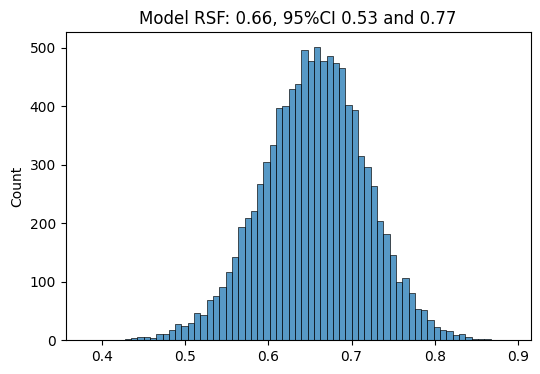

In [19]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(model_rsf_cindex, ax=ax)

alpha= 0.05
ax.set_title('Model RSF: %.2f, %.0f%%CI %.2f and %.2f' % (model_rsf_ci[0], (1-alpha)*100, model_rsf_ci[1], model_rsf_ci[2]))

### 2.3. Predicting

Random Survival Forest predictions are performed by aggregating predictions of individual trees in the ensemble. RSF can give a **non-parametrical** estimation of the **survival and cumulative hazard functions** using the **Kaplan-Meier** and **Nelson-Aalen** estimator, respectively. Risk scores can also be computed as terminal nodes have a expected number of events.

In [20]:
# Predict risk scores
patients= [2,4,14]
pd.DataFrame(data={'Predicted risk scored': model_rsf.predict(X_test.iloc[patients]),
                   'Labels':y_test[patients].tolist()},
             index=pd.Index(data=patients, name='Patients'))

,Predicted risk scored,Labels
Patients,,
2,3.733514,"(True, 19.0)"
4,1.614283,"(False, 2271.0)"
14,1.897647,"(False, 1816.0)"


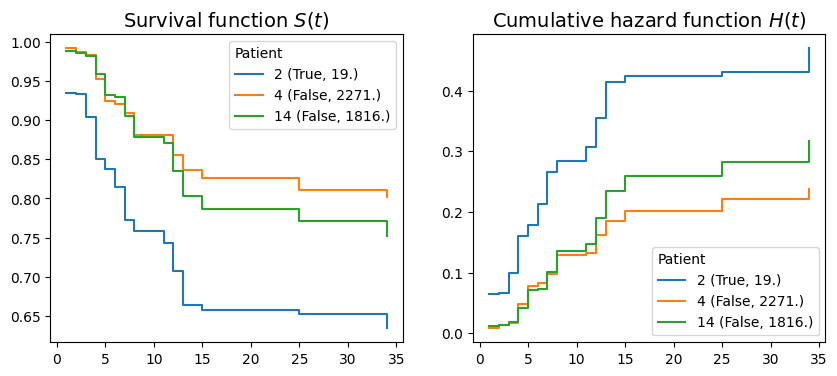

In [21]:
# Predict Survival function and Cumulative Hazard function
patients= [2,4,14]

pred_surv= model_rsf.predict_survival_function(X_test.iloc[patients])
pred_hazard= model_rsf.predict_cumulative_hazard_function(X_test.iloc[patients])


fig, axs= plt.subplots(1,2, figsize=(10,4))

for i, s in enumerate(pred_surv):
    axs[0].step(s.x, s.y, where='post', label=str(patients[i]) + ' ' + str(y_test[patients[i]]))
    
for i, s in enumerate(pred_hazard):
    axs[1].step(s.x, s.y, where='post', label=str(patients[i]) + ' ' + str(y_test[patients[i]]))

axs[0].set_title('Survival function $S(t)$', fontsize=14)
axs[1].set_title('Cumulative hazard function $H(t)$', fontsize=14)
leg1= axs[0].legend(title='Patient'); leg1._legend_box.align= 'left'
leg2= axs[1].legend(title='Patient'); leg2._legend_box.align= 'left'

### 3. Gradient Boosted Model

- **Training**
    - **Survival trees**
        - Study the optimal number of base learners.
        - Find the optimal hyperparameters.
    - **Component-wise least squares**
        - Study the optimal number of base learners.
        - Find the optimal hyperparameters.
        
- **Testing**
    - Feature importance.
        - GB tree.
        - GB least squares.
    - Bootstrapping confidence intervals.
    
- **Predicting**

**Gradient boosting (GB)** is a machine learning technique able to optimize a differentiable loss function by building a model based on multiple stepwise *base learners*. Although any model can be used, in this project *survival trees* and *least squares estimators* are used as base learners. The base learners are often very simple models that are only slightly better than random guessing, which is why they are also referred to as weak learners. The predictions are combined in an additive manner, where the addition of each base model improves (or “boosts”) the overall model.

A gradient boosted model is similar to a RSF, in the sense that it relies on multiple base learners to produce an overall prediction, but differs in how those are combined. While a RSF fits a set of survival trees independently and then averages their predictions, a GB model is constructed sequentially in a greedy stagewise fashion.

### 3.1. Training

- **Survival trees**
    - Study the optimal number of base learners.
    - Find the optimal hyperparameters.
- **Component-wise least squares**
    - Study the optimal number of base learners.
    - Find the optimal hyperparameters.


GB models can be based on different base learnears. In this project two are used:
   - Survival trees
   - Component-wise least squares.

The loss function used is the **partial likelihood loss of Cox’s proportional hazards regression**. Therefore, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model with the additive model.

In [22]:
X_train, X_test, y_train, y_test= train_test_split(df_X_nonan, y_nonan, test_size=0.25, random_state=0)

#### 3.1.1. Survival trees

- **Study the optimal number of base learners**.
- **Find the optimal hyperparameters**.

##### 3.1.1.1. Study the optimal number of base learners

Find the optimal number of base learners to guide the *GridSearch*.

In [23]:
# Find the optimal number of base learners
scores_gb_cph_tree= {}

gb_cph_tree_= GradientBoostingSurvivalAnalysis(loss='coxph',
                                               learning_rate=0.5,
                                               min_samples_split=2,
                                               min_samples_leaf=1,
                                               max_depth=4,
                                               subsample=1,
                                               criterion='friedman_mse',
                                               random_state=0)

for i in range(1, 31):
    n_estimators= i * 5
    gb_cph_tree_.set_params(n_estimators=n_estimators)
    gb_cph_tree_.fit(X_train, y_train)
    scores_gb_cph_tree[n_estimators]= gb_cph_tree_.score(X_test, y_test)

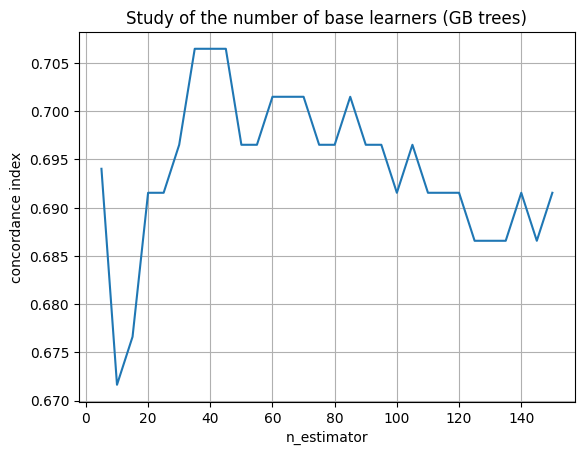

In [24]:
x, y= zip(*scores_gb_cph_tree.items())
plt.plot(x, y)
plt.title('Study of the number of base learners (GB trees)')
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True)

##### 3.1.1.2. Find the optimal hyperparameters

Find the optimal hyperparameters.

In [25]:
# Find the optimal Gradient Boosted Model hyperparameters

gb_cph_tree= GradientBoostingSurvivalAnalysis(loss='coxph', subsample=1, criterion='friedman_mse', random_state=0)


param_grid_gb_cph_tree= {'n_estimators': [20,40,60],
                         'learning_rate': [0.1,0.5,0.8],
                         'min_samples_split': [2,3,4],
                         'min_samples_leaf': [1,2],
                         'max_depth': [3,4,5]}


gb_cph_tree_gcv= GridSearchCV(estimator=gb_cph_tree,
                              param_grid=param_grid_gb_cph_tree,
                              error_score='raise',
                              n_jobs=1,
                              cv=cv)


t0= time()
gb_cph_tree_gcv.fit(X_train, y_train)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gb_cph_tree_gcv.best_params_, '\n')

gb_cph_tree_gcv_cindex= gb_cph_tree_gcv.score(X_test, y_test)
print('GB c-index: %.4f' % (gb_cph_tree_gcv_cindex))

Fitting time: 1.38 min 

Best hyperparameters:
{'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40} 

GB c-index: 0.7065


In [26]:
# Final model
model_gb_cph_tree= GradientBoostingSurvivalAnalysis(loss='coxph', subsample=1, criterion='friedman_mse', random_state=0)
model_gb_cph_tree.set_params(**gb_cph_tree_gcv.best_params_)
model_gb_cph_tree.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(learning_rate=0.5, max_depth=4,
                                 n_estimators=40, random_state=0, subsample=1)

#### 3.1.2. Component-wise least squares

- **Study the optimal number of base learners**.
- **Find the optimal hyperparameters**.

Same analysis using component-wise least squares base learners. With component-wise least squares base learners the overall ensemble is a **linear model**, whereas with tree-based learners it will be a non-linear model.

##### 3.1.2.1. Study the optimal number of base learners

Find the optimal number of base learners to guide the *GridSearch*.

In [27]:
# Find the optimal number of base learners
scores_gb_cph_ls= {}

gb_cph_ls_= ComponentwiseGradientBoostingSurvivalAnalysis(loss='coxph', learning_rate=0.1, subsample=1, random_state=0)

for i in range(1, 61):
    n_estimators= i * 10
    gb_cph_ls_.set_params(n_estimators=n_estimators)
    gb_cph_ls_.fit(X_train, y_train)
    scores_gb_cph_ls[n_estimators]= gb_cph_ls_.score(X_test, y_test)

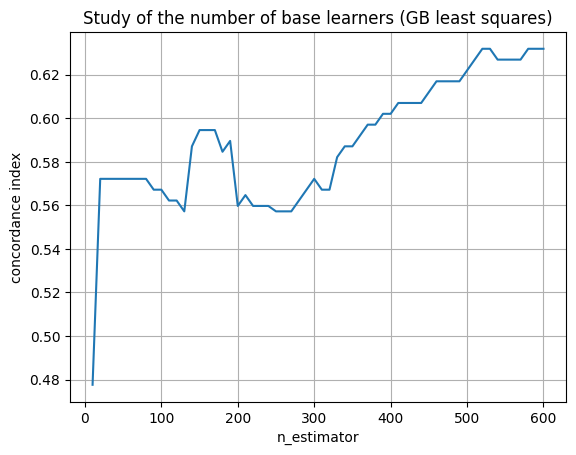

In [28]:
x, y= zip(*scores_gb_cph_ls.items())
plt.plot(x, y)
plt.title('Study of the number of base learners (GB least squares)')
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True)

##### 3.1.2.2. Find the optimal hyperparameters

Find the optimal hyperparameters.

In [29]:
# Find the optimal hyperparameters

gb_cph_ls= ComponentwiseGradientBoostingSurvivalAnalysis(loss='coxph', subsample=1, random_state=0)

param_grid_gb_cph_ls= {'n_estimators': [400,450,500], 'learning_rate': [0.1,0.5,0.8]}


gb_cph_ls_gcv= GridSearchCV(estimator=gb_cph_ls,
                            param_grid=param_grid_gb_cph_ls,
                            error_score='raise',
                            n_jobs=1,
                            cv=cv)


t0= time()
gb_cph_ls_gcv.fit(X_train, y_train)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gb_cph_ls_gcv.best_params_, '\n')

gb_cph_ls_gcv_cindex= gb_cph_ls_gcv.score(X_test, y_test)
print('GB least squares c-index: %.4f' % (gb_cph_ls_gcv_cindex))

Fitting time: 0.60 min 

Best hyperparameters:
{'learning_rate': 0.8, 'n_estimators': 500} 

GB least squares c-index: 0.6468


In [30]:
# Final model
model_gb_cph_ls= ComponentwiseGradientBoostingSurvivalAnalysis(loss='coxph', subsample=1, random_state=0)
model_gb_cph_ls.set_params(**gb_cph_ls_gcv.best_params_)
model_gb_cph_ls.fit(X_train, y_train)

ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=0.8,
                                              n_estimators=500, random_state=0,
                                              subsample=1)

### 3.2. Testing

- **Feature importance**.
    - GB tree.
    - GB least squares.
- **Boostrapping confidence intervals**.

#### 3.2.1. Feature importance

Study the feature importance for each model.

#### 3.2.1.1. GB tree.

It is straightforward to retrieve importance scores after the boosted trees have been fitted. This is a metric that indicates the usefulness of each feature, and as higher it is, as more relative importance the feature has. Importance is calculated for each tree and then averaged across all decision trees within the model.

In [31]:
# Percentage of feature importance
df_gb_cph_tree=pd.DataFrame(data={'variable':  model_gb_cph_tree.feature_names_in_,
                                  'importance':  model_gb_cph_tree.feature_importances_},
                       index=X_test.columns).sort_values(by='importance', ascending=False)

df_gb_cph_tree

,variable,importance
tgcs,tgcs,0.213154
urea,urea,0.179324
onset_h,onset_h,0.096672
glucose,glucose,0.065374
neurological_diseases,neurological_diseases,0.052225
maxfibrinogen,maxfibrinogen,0.051487
potasium,potasium,0.047800
prothrombin_activity,prothrombin_activity,0.043068
creatinine,creatinine,0.041769
hematocrit,hematocrit,0.040554


#### 3.2.1.2. GB least squares.

The final **least squares model** is much more interpretable than the other model. It is possible to print regression coefficients and know easily how the model is predicting.

In [32]:
coef= pd.Series(model_gb_cph_ls.coef_, ['Intercept'] + df_X_nonan.columns.tolist())

print('Number of non-zero coefficients:', (coef != 0).sum())
coef_nz= coef[coef != 0]
coef_order= coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 20


neurological_diseases       1.385784
visual_disturbances        -1.287516
llwlimb_mimpairment         1.125370
altered_consciousness       0.623873
aspirin                    -0.452825
primary_ich                 0.442403
headache                   -0.390418
sex                         0.328709
ruplimb_mimpairment         0.310630
tgcs                       -0.198764
antidiabetics               0.180660
nfamily_medhist            -0.144526
anisocoria                  0.088691
hypolipidemics             -0.031586
structural_heart_disease    0.021903
emesis                     -0.021600
age                         0.005458
glucose                     0.002291
maxfibrinogen              -0.000720
onset_h                    -0.000573
dtype: float64

#### 3.2.2. Boostrapping confidence intervals

In [33]:
def boots_gb_cph (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        gb_cph= GradientBoostingSurvivalAnalysis(loss='coxph', subsample=1, criterion='friedman_mse', random_state=0)
        
        gb_cph.set_params(**params_)
                
        gb_cph.fit(x.values[idx_train,], y[idx_train])
        
        cindex= gb_cph.score (x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [34]:
model_gb_cph_tree_cindex, model_gb_cph_tree_ci= boots_gb_cph (x=df_X_nonan, y=y_nonan, train_size=0.8, params_=gb_cph_tree_gcv.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Model GB tree: 0.62, 95%CI 0.48 and 0.76')

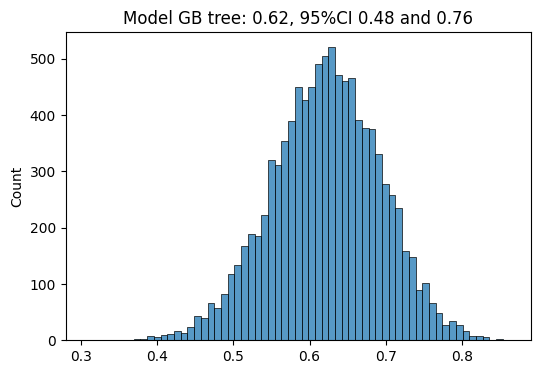

In [35]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(model_gb_cph_tree_cindex, ax=ax)

alpha= 0.05
ax.set_title('Model GB tree: %.2f, %.0f%%CI %.2f and %.2f' % (model_gb_cph_tree_ci[0], (1-alpha)*100, model_gb_cph_tree_ci[1], model_gb_cph_tree_ci[2]))

### 3.3. Predicting

GB model predicts risk scores, but not the Survival or Cumulative Hazard functions.

In [36]:
# Predict risk scores
patients= [2,4,14]
pd.DataFrame(data={'Predicted risk scored': model_gb_cph_tree.predict(X_test.iloc[patients]),
                   'Labels':y_test[patients].tolist()},
             index=pd.Index(data=patients, name='Patients'))

,Predicted risk scored,Labels
Patients,,
2,3.706713,"(True, 19.0)"
4,-1.336029,"(False, 2271.0)"
14,0.015550,"(False, 1816.0)"


### 4. Accelerated Failure Time model (parametric approach)

- **Training**
    - Study the optimal number of base learners.
    - Find the optimal hyperparameters.
        
- **Testing**
    - Feature importance.
    - Bootstrapping confidence intervals.
    
- **Predicting**

**Accelerated Failure Time (AFT)** model is a parametric approach to estimate survival and cumulative hazard functions. Whereas Cox’s proportional hazards model, a semi-parametric approach, assumes that features only influence the hazard function via a constant multiplicative factor, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. Mathematically, proportional hazards model assumes that the effect of a covariate is to multiply the hazard by some constant, an AFT model assumes that the effect of a covariate is to accelerate or decelerate the life course of a disease by some constant. In proportional hazards model covariates affect hazards, and in an AFT affect time.

### 4.1. Training

- **Study the optimal number of base learners.**
- **Find the optimal hyperparameters.**

In [37]:
X_train, X_test, y_train, y_test= train_test_split(df_X_nonan, y_nonan, test_size=0.25, random_state=0)

In [38]:
y_train[y_train['Survival_in_days'] == 0]= 0.1

#### 4.1.1. Study the optimal number of base learners.

Study the optimal number of base learners.

In [39]:
# To obtain an AFT model, just set the loss='ipcwls'

scores_gb_aft_ls= {}

gb_aft_ls_= GradientBoostingSurvivalAnalysis(loss='ipcwls', learning_rate=0.1, subsample=1, random_state=0)

for i in range(1, 51):
    n_estimators= i * 2
    gb_aft_ls_.set_params(n_estimators=n_estimators)
    gb_aft_ls_.fit(X_train, y_train)
    scores_gb_aft_ls[n_estimators]= gb_aft_ls_.score(X_test, y_test)

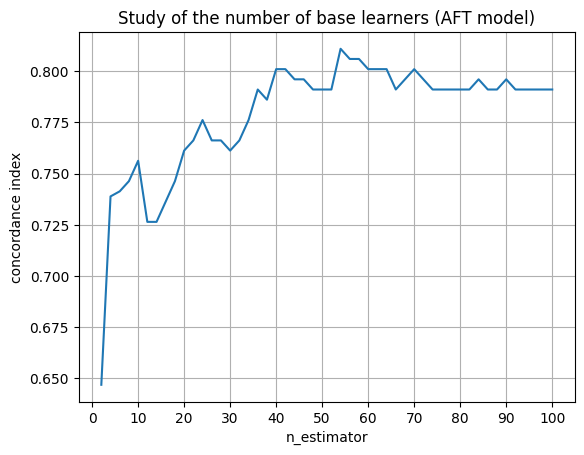

In [40]:
x, y= zip(*scores_gb_aft_ls.items())
plt.plot(x, y)
plt.title('Study of the number of base learners (AFT model)')
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(True)

#### 4.1.2. Find the optimal hyperparameters.

Find the optimal hyperparameters.

In [41]:
# Find the optimal Gradient Boosted Model hyperparameters

gb_aft_ls= GradientBoostingSurvivalAnalysis(loss='ipcwls', subsample=1, random_state=0)

param_grid_gb_aft_ls= {'n_estimators': [40,50,55,60,65], 'learning_rate': [0.1,0.5]}

gb_aft_ls_gcv= GridSearchCV(estimator=gb_aft_ls,
                            param_grid=param_grid_gb_aft_ls,
                            error_score='raise',
                            n_jobs=1,
                            cv=cv)


t0= time()
gb_aft_ls_gcv.fit(X_train, y_train)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gb_aft_ls_gcv.best_params_, '\n')

gb_aft_ls_gcv_cindex= gb_aft_ls_gcv.score(X_test, y_test)
print('GB c-index: %.4f' % (gb_aft_ls_gcv_cindex))

Fitting time: 0.13 min 

Best hyperparameters:
{'learning_rate': 0.1, 'n_estimators': 60} 

GB c-index: 0.8010


In [42]:
model_gb_aft_ls= GradientBoostingSurvivalAnalysis(loss='ipcwls', subsample=1, random_state=0)
model_gb_aft_ls.set_params(**gb_aft_ls_gcv.best_params_)
model_gb_aft_ls.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(loss='ipcwls', n_estimators=60, random_state=0,
                                 subsample=1)

### 4.2. Testing

- **Feature importance.**
- **Bootstrapping confidence intervals.**

#### 4.2.1. Feature importance

In [43]:
# Percentage of feature importance
df_gb_aft_ls=pd.DataFrame(data={'variable':    model_gb_aft_ls.feature_names_in_,
                                'importance':  model_gb_aft_ls.feature_importances_},
                       index=X_test.columns).sort_values(by='importance', ascending=False)

df_gb_aft_ls

,variable,importance
tgcs,tgcs,0.282051
urea,urea,0.112002
potasium,potasium,0.078525
maxfibrinogen,maxfibrinogen,0.070842
glucose,glucose,0.066934
headache,headache,0.052233
onset_h,onset_h,0.048662
prothrombin_activity,prothrombin_activity,0.046857
creatinine,creatinine,0.042790
llwlimb_mimpairment,llwlimb_mimpairment,0.040841


#### 4.2.2. Bootstrapping confidence intervals.

In [44]:
def boots_gb_aft_ls (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        gb_aft_ls= GradientBoostingSurvivalAnalysis(loss='ipcwls', subsample=1, random_state=0)
        
        gb_aft_ls.set_params(**params_)
                
        gb_aft_ls.fit(x.values[idx_train,], y[idx_train])
        
        cindex= gb_aft_ls.score (x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [45]:
y_nonan_non0= y_nonan.copy()
y_nonan_non0[y_nonan_non0['Survival_in_days'] == 0]= 0.1

model_gb_aft_ls_cindex, model_gb_aft_ls_ci= boots_gb_aft_ls (x=df_X_nonan, y=y_nonan_non0, train_size=0.8, params_=gb_aft_ls_gcv.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Model GB AFT: 0.66, 95%CI 0.52 and 0.78')

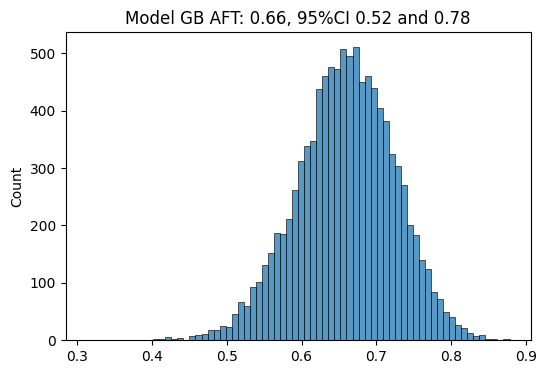

In [49]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(model_gb_aft_ls_cindex, ax=ax)

alpha= 0.05
ax.set_title('Model GB AFT: %.2f, %.0f%%CI %.2f and %.2f' % (model_gb_aft_ls_ci[0], (1-alpha)*100, model_gb_aft_ls_ci[1], model_gb_aft_ls_ci[2]))

### 4.3. Predicting

Prediction include an individual risk score.

In [50]:
# Predict risk scores
patients= [2,4,14]
pd.DataFrame(data={'Predicted risk scored': model_gb_aft_ls.predict(X_test.iloc[patients]),
                   'Labels':y_test[patients].tolist()},
             index=pd.Index(data=patients, name='Patients'))

,Predicted risk scored,Labels
Patients,,
2,18.098705,"(True, 19.0)"
4,1721.092516,"(False, 2271.0)"
14,573.460361,"(False, 1816.0)"
